# Importing libraries

In [1]:
import mediapipe as mp
import glob
import cv2
import csv
import copy
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
%matplotlib inline
%config InlineBackend.figure_format='retina'
pd.plotting.register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Setting up media pipe

In [2]:
mpHands = mp.solutions.hands
hands = mpHands.Hands()
mpDraw = mp.solutions.drawing_utils

# Define useful functions

In [3]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point


def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalize data - scaled between -1 and 1
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list


def logging_csv(csv_path, class_name, landmark_list):
    with open(csv_path, 'a', newline="") as f:
        writer = csv.writer(f)
        writer.writerow([class_name, *landmark_list])
    return


# Writing landmark points in keypoint data csv

In [ ]:
# define csv file to write
csv_path = 'keypoint_classifier/keypoint_data.csv'

for file in glob.glob('training_images/*.jpg'):
    print("Reading new file: " + str(file))
    # get feature name
    class_name = str(file)[16:18]
    # "f1" -> 0, "f2" -> 1, "f3" -> 2, "f4" -> 3
    class_number = int(class_name[1]) - 1
    # read image from file
    image = cv2.imread(file)
    # option to rotate
    image = cv2.rotate(image, cv2.ROTATE_180)
    # debug_image as BGR
    debug_image = copy.deepcopy(image)
    # image as RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # esxtract skeleton points with mediapipe
    results = hands.process(image)

    if results.multi_hand_landmarks:
        for hand_landmarks, handedness in zip(results.multi_hand_landmarks,
                                                results.multi_handedness):
            # Landmark calculation
            landmark_list = calc_landmark_list(debug_image, hand_landmarks)
            # Conversion to relative coordinates / normalized coordinates
            pre_processed_landmark_list = pre_process_landmark(landmark_list)
            # Write to the dataset file
            logging_csv(csv_path, class_number, pre_processed_landmark_list)


# Specify paths for data and model

In [5]:
dataset = 'keypoint_classifier/keypoint_data.csv'
model_save_path = 'keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [6]:
NUM_CLASSES = 4

# Dataset reading

In [7]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [8]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(396, 42) (396,)
(132, 42) (132,)


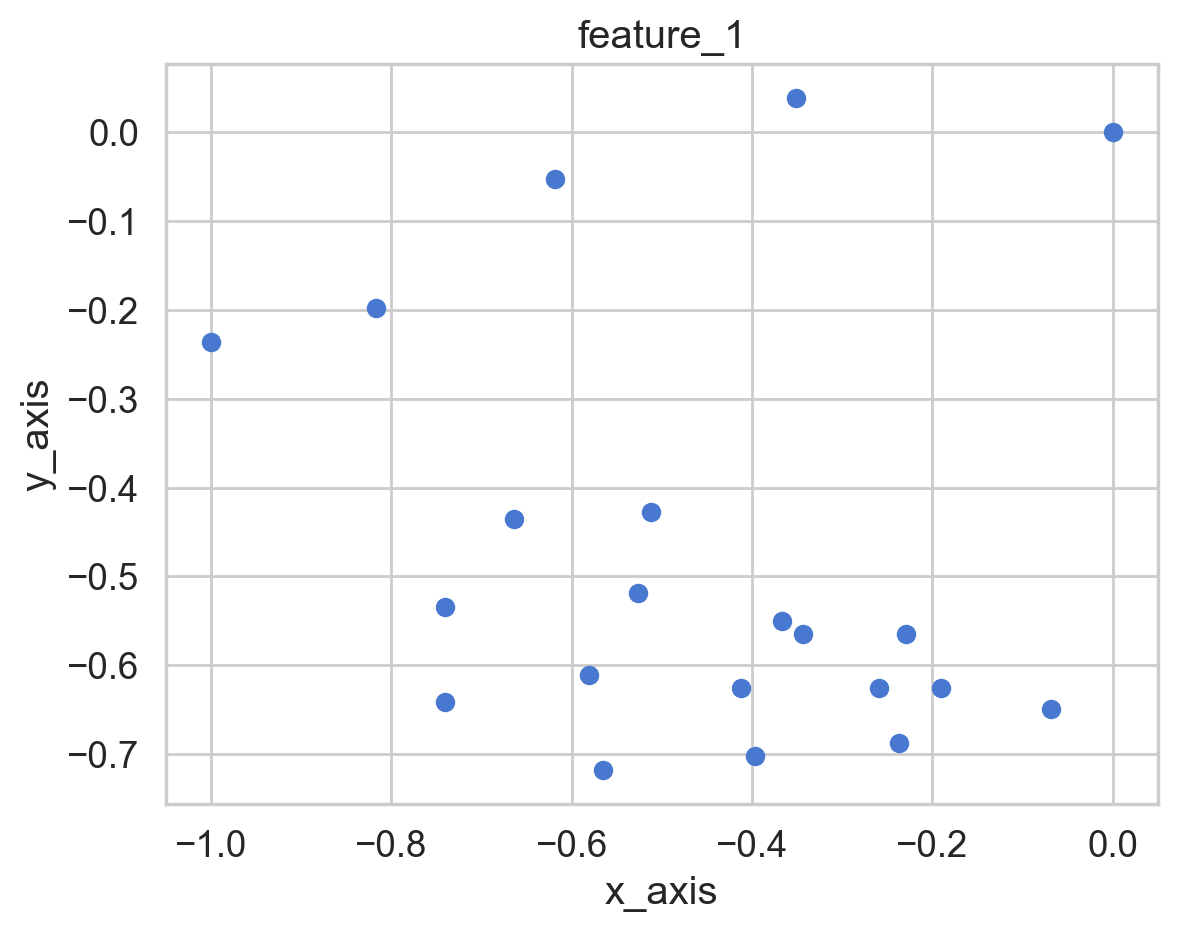

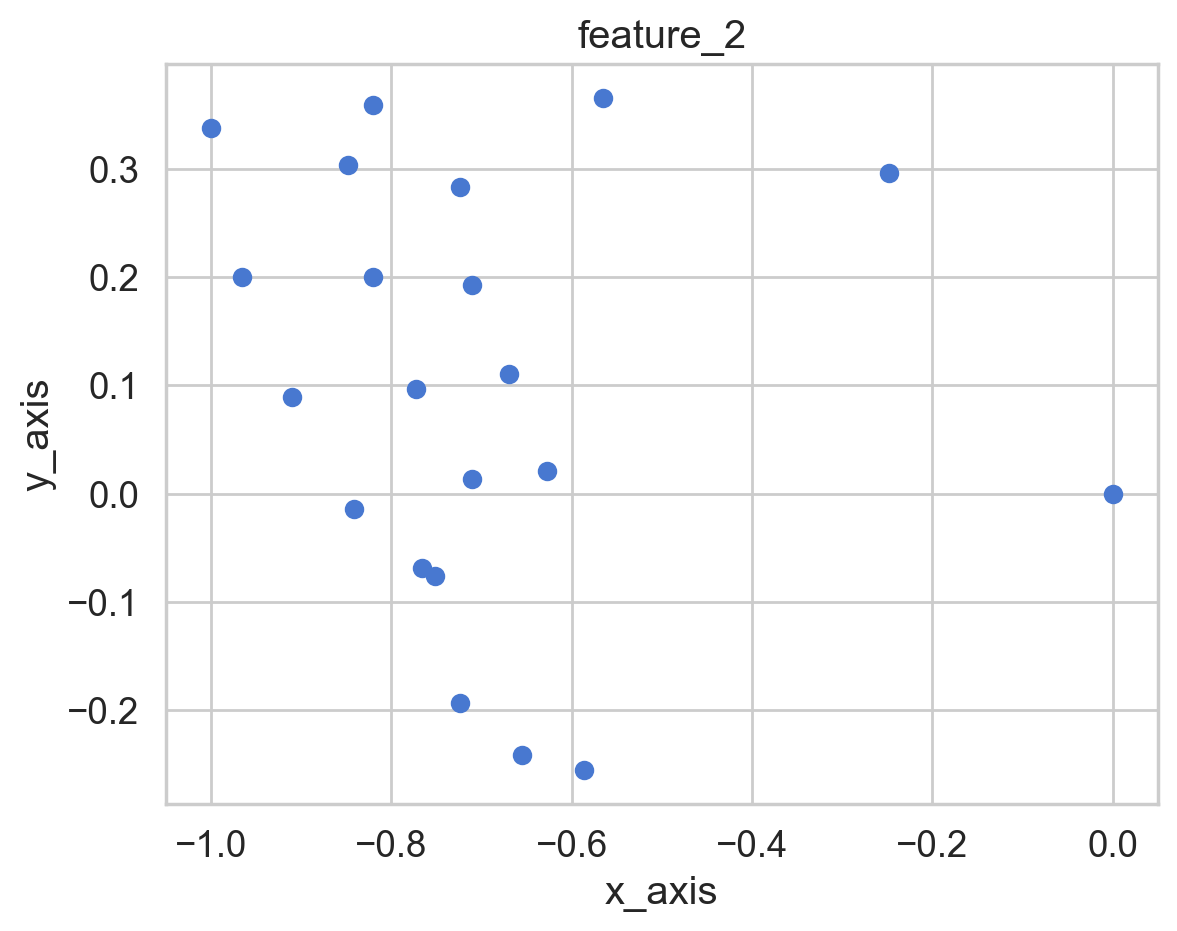

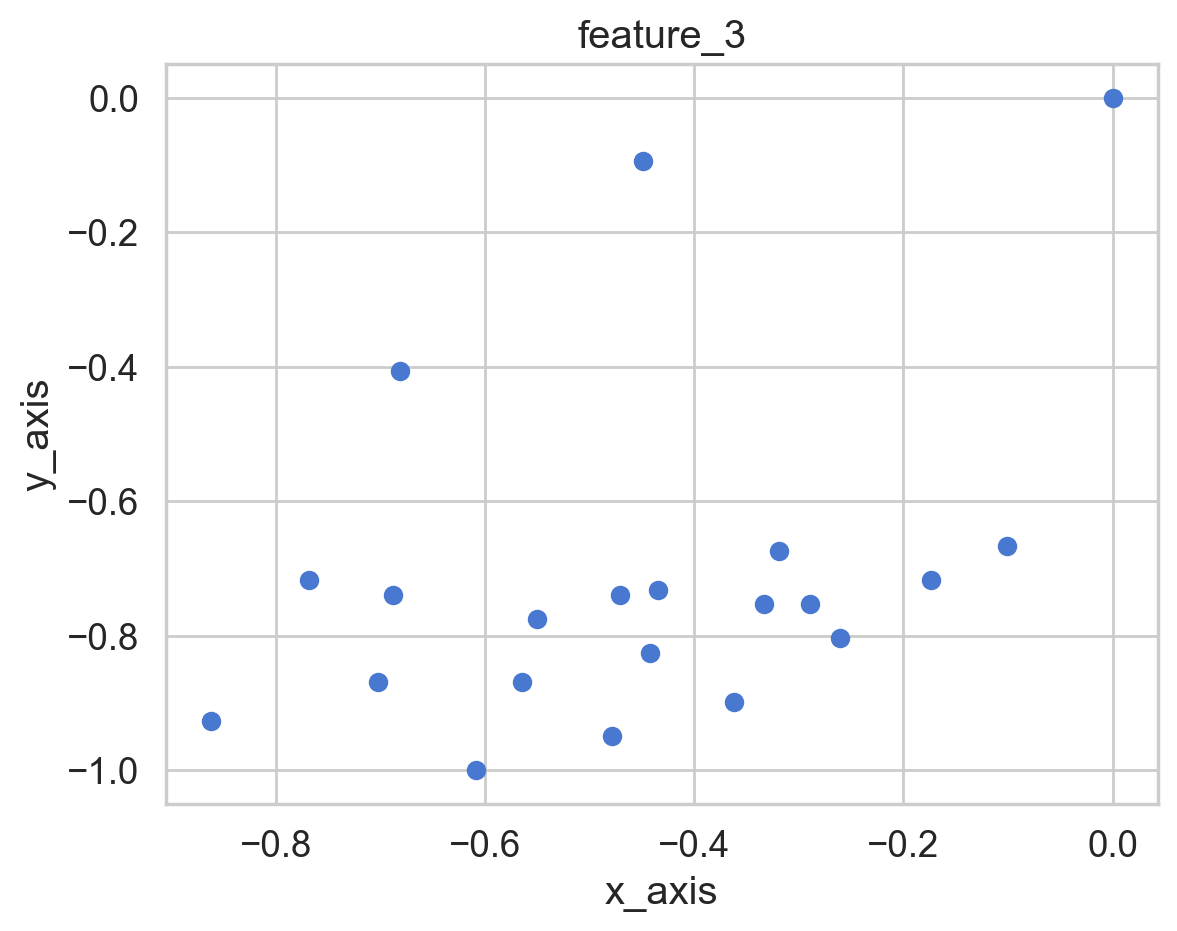

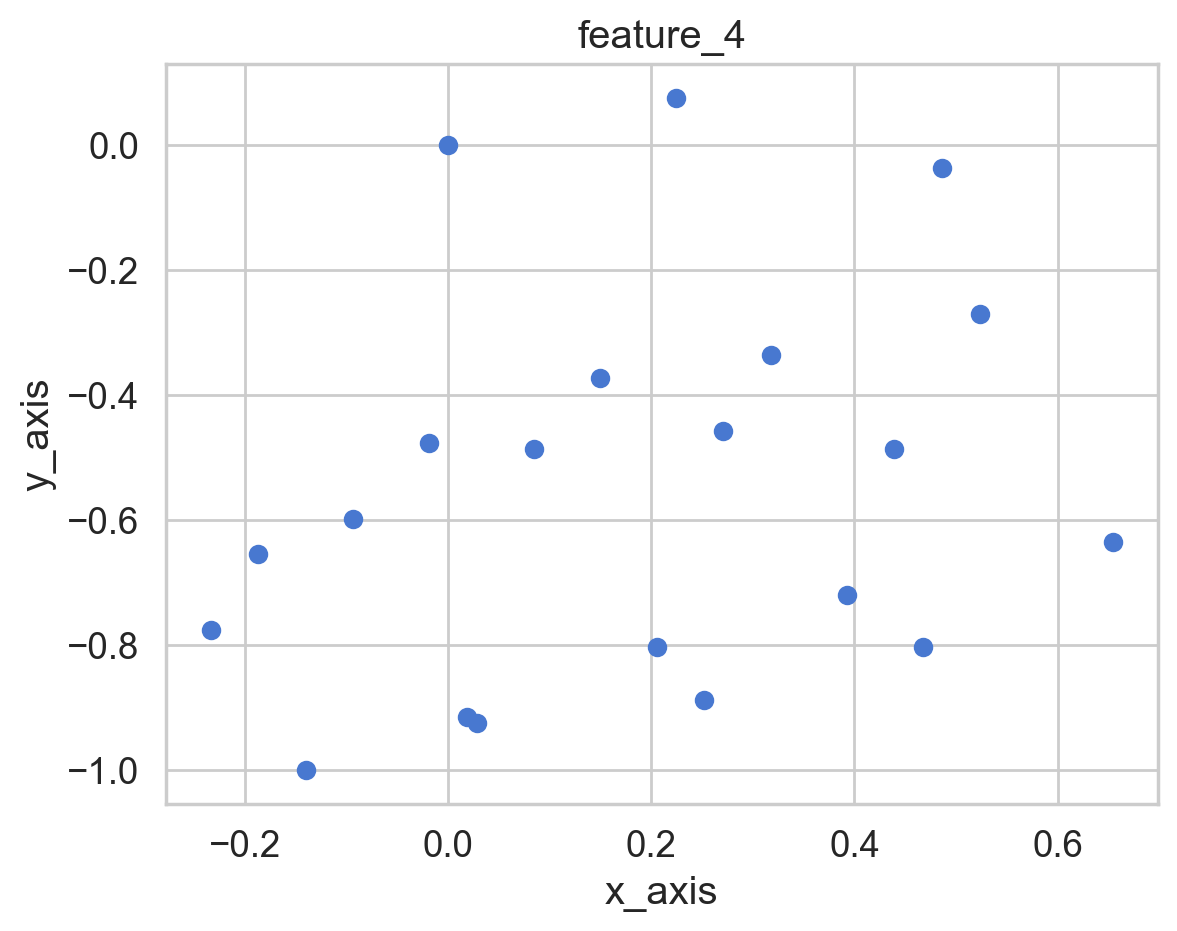

In [12]:
def plot_df_keypoint(df, fig_name):
    array_x = []
    array_y = []
    for i in range(42):
        if(i%2 == 0):
            array_x.append(df[i])
            # print('x = ', X_train[0][i])
            array_y.append(df[i+1])
            # print('y = ', X_train[0][i+1])
    plt.scatter(array_x, array_y)
    plt.xlabel('x_axis')
    plt.ylabel('y_axis')
    plt.title(fig_name)
    plt.show()

plot_df_keypoint(df=X_train[0], fig_name=f'feature_{y_train[0]+1}')
plot_df_keypoint(df=X_train[98], fig_name=f'feature_{y_train[98]+1}')
plot_df_keypoint(df=X_train[198], fig_name=f'feature_{y_train[198]+1}')
plot_df_keypoint(df=X_train[21], fig_name=f'feature_{y_train[21]+1}')

# Model building

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[cp_callback, es_callback]
)


Epoch 1/1000
1/3 [=========>....................] - ETA: 1s - loss: 1.3596 - accuracy: 0.3750
Epoch 1: saving model to keypoint_classifier\keypoint_classifier.hdf5
3/3 [==============================] - 1s 244ms/step - loss: 1.3740 - accuracy: 0.2962 - val_loss: 1.3426 - val_accuracy: 0.3048
Epoch 2/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.3358 - accuracy: 0.2969
Epoch 2: saving model to keypoint_classifier\keypoint_classifier.hdf5
3/3 [==============================] - 0s 40ms/step - loss: 1.3222 - accuracy: 0.3344 - val_loss: 1.3237 - val_accuracy: 0.3238
Epoch 3/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.2491 - accuracy: 0.3906
Epoch 3: saving model to keypoint_classifier\keypoint_classifier.hdf5
3/3 [==============================] - 0s 45ms/step - loss: 1.2361 - accuracy: 0.3599 - val_loss: 1.3080 - val_accuracy: 0.3429
Epoch 4/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.2234 - accuracy: 0.3750
Epoch 4: saving model to keyp

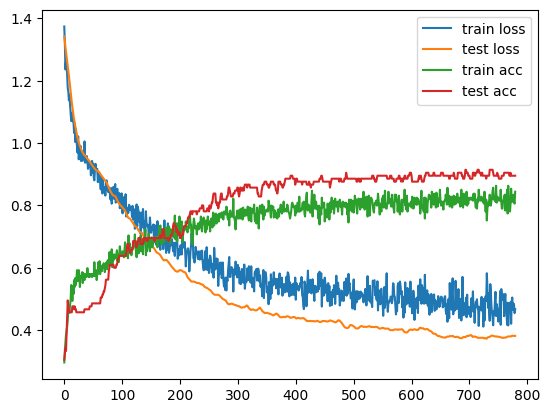

In [15]:
# Plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='test acc')
plt.legend()

In [16]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 29ms/step - loss: 0.3814 - accuracy: 0.8952


In [17]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [18]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 70ms/step
[6.6182830e-11 9.9052411e-01 9.4758756e-03 1.0336438e-09]
1


# Confusion matrix

4/4 [==============================] - 0s 3ms/step
Confusion Matrix


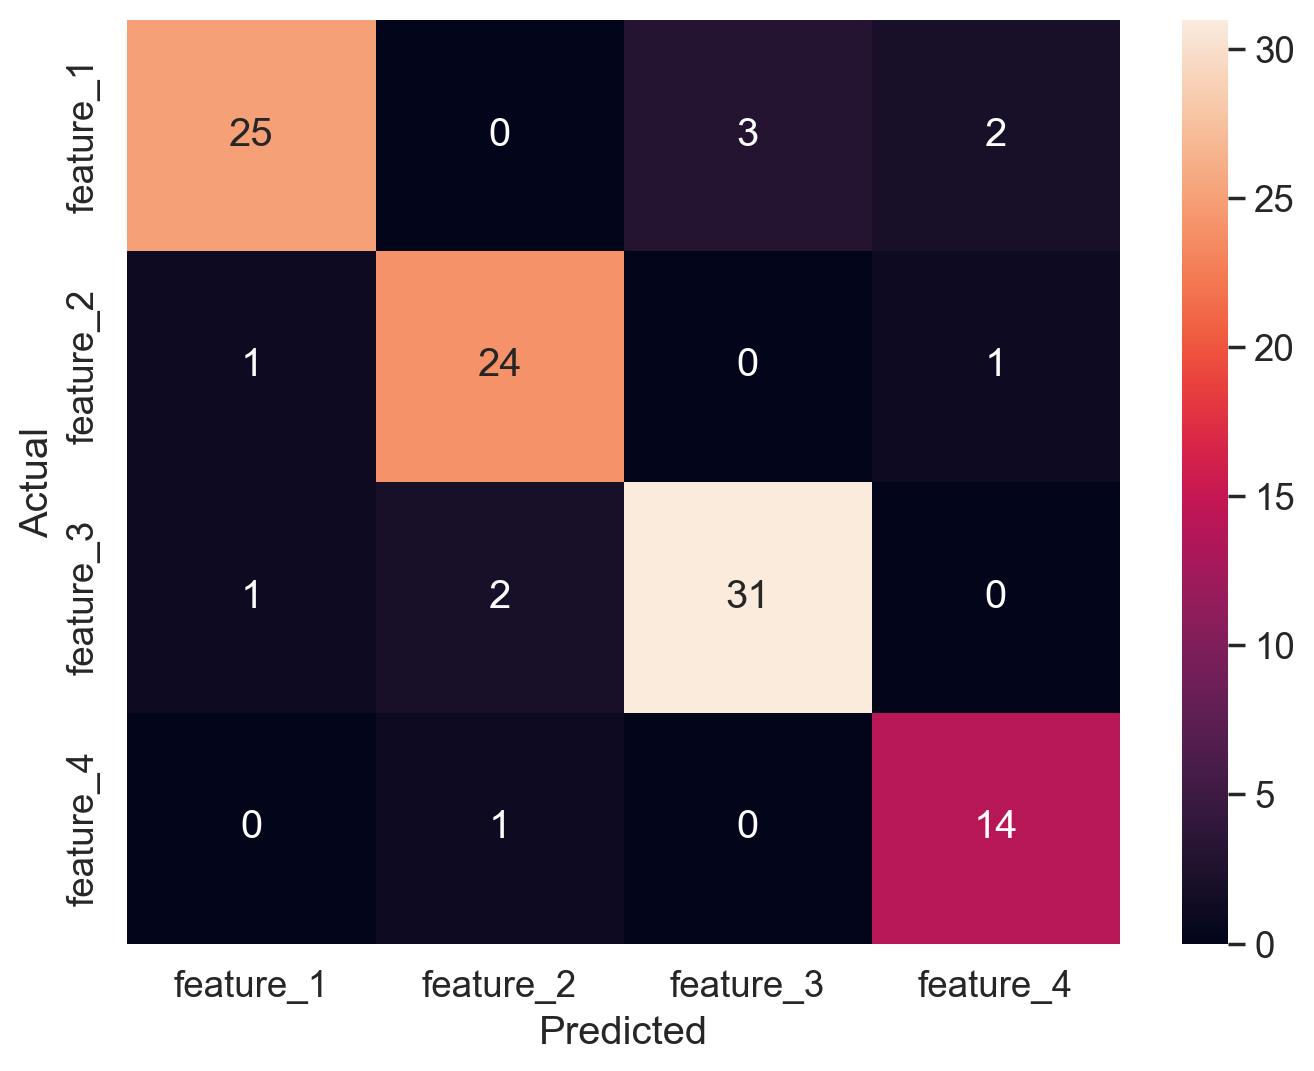

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.83      0.88        30
           1       0.89      0.92      0.91        26
           2       0.91      0.91      0.91        34
           3       0.82      0.93      0.87        15

    accuracy                           0.90       105
   macro avg       0.89      0.90      0.89       105
weighted avg       0.90      0.90      0.90       105



In [19]:
def print_confusion_matrix(y_true, y_pred):
    class_names = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='g'
        )
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

y_pred = model.predict(X_test)
print('Confusion Matrix')
print_confusion_matrix(y_test, np.argmax(y_pred, axis=1))
print('Classification Report')
print(classification_report(y_test, np.argmax(y_pred, axis=1)))

# Saving the model

In [20]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

# Convert to model for Tensorflow-Lite

In [21]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\YQ\AppData\Local\Temp\tmpixvg8dlg\assets


INFO:tensorflow:Assets written to: C:\Users\YQ\AppData\Local\Temp\tmpixvg8dlg\assets


6544

# Input and Output of the model

In [22]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[ 1 42] <class 'numpy.float32'>

1 output(s):
[1 4] <class 'numpy.float32'>
